In [90]:
import pandas as pd
from datetime import datetime
from plotnine import *

In [91]:
# Set variables:
NIWA_MD = 2.4 
WQO = 0.14

In [92]:
#import concentration data
df = pd.read_csv('data/catchment_NNO3_all.csv')
df.head()

,GSnum,name,ts,Value,Quality
0,1160116,Catherina Creek at Catherina Creek Road,2020-12-27T00:00:00Z,0.142,1
1,1160116,Catherina Creek at Catherina Creek Road,2020-12-27T00:15:00Z,0.153,1
2,1160116,Catherina Creek at Catherina Creek Road,2020-12-27T00:30:00Z,0.133,1
3,1160116,Catherina Creek at Catherina Creek Road,2020-12-27T00:45:00Z,0.129,1
4,1160116,Catherina Creek at Catherina Creek Road,2020-12-27T01:00:00Z,0.130,1


In [93]:
#import site information
sitelist = pd.read_csv('data/sitelist.csv')
sitelist.head()

,Basin,Catchment,GSnum,Site name,Site code,Latitude (GDA2020),Longitude (GDA2020),Site type,Stream order,Stream habit
0,Herbert,Herbert River,1160115,Broadwater Creek at Day Use,BCD,-18.41633,145.94393,Reference,4,Natural
1,Herbert,Catherina Creek,1160116,Catherina Creek at Catherina Creek Road,CCC,-18.59907,146.23627,End of System,3,Natural
2,Herbert,Herbert River,1160117,Elphinstone Creek at Copley Road,ECC,-18.46506,145.96146,Impact,4,Natural
3,Herbert,Francis Creek,1160118,Francis Creek at Weir,FCW,-18.76673,146.13407,Impact,5,Ephemeral
4,Herbert,Herbert River,1160119,Herbert River at John Row Bridge,HRJ,-18.62831,146.16486,End of System,7,Tidal


In [94]:

# Subset to include only 'GSnum' and 'Value' columns
subset_df = df[['GSnum', 'Value']]
# Group by 'GSnum' and calculate the median for the 'Value' and 'Quality' columns
median_summary = subset_df.groupby('GSnum').median().reset_index()
# Rename the 'Value' column to 'median'
median_summary.rename(columns={'Value': 'median'}, inplace=True)
# Perform a left join of the original DataFrame with the median summary DataFrame
merged_df = pd.merge(df, median_summary, on='GSnum', how='left')

merged_df = pd.merge(merged_df, sitelist[['GSnum', 'Site type', 'Site code']], on='GSnum', how='left')
# Concatenate columns with separator
merged_df['combined_col'] = merged_df['Site type'] + ' // ' + merged_df['Site code']
merged_df.head()

,GSnum,name,ts,Value,Quality,median,Site type,Site code,combined_col
0,1160116,Catherina Creek at Catherina Creek Road,2020-12-27T00:00:00Z,0.142,1,0.098,End of System,CCC,End of System // CCC
1,1160116,Catherina Creek at Catherina Creek Road,2020-12-27T00:15:00Z,0.153,1,0.098,End of System,CCC,End of System // CCC
2,1160116,Catherina Creek at Catherina Creek Road,2020-12-27T00:30:00Z,0.133,1,0.098,End of System,CCC,End of System // CCC
3,1160116,Catherina Creek at Catherina Creek Road,2020-12-27T00:45:00Z,0.129,1,0.098,End of System,CCC,End of System // CCC
4,1160116,Catherina Creek at Catherina Creek Road,2020-12-27T01:00:00Z,0.130,1,0.098,End of System,CCC,End of System // CCC


In [95]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765851 entries, 0 to 765850
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   GSnum         765851 non-null  int64  
 1   name          765851 non-null  object 
 2   ts            765851 non-null  object 
 3   Value         765851 non-null  float64
 4   Quality       765851 non-null  int64  
 5   median        765851 non-null  float64
 6   Site type     765851 non-null  object 
 7   Site code     765851 non-null  object 
 8   combined_col  765851 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 52.6+ MB


In [100]:
# Parse the 'Date' column from the timestamp
merged_df['ts'] = pd.to_datetime(merged_df['ts'])

# Group by month and calculate median of 'Value' column
monthly_median = merged_df.groupby([merged_df['ts'].dt.month, 'name', 'combined_col'])['Value'].max()
monthly_median.head()

ts  name                                     combined_col        
1   Broadwater Creek at Day Use              Reference // BCD        0.067
    Catherina Creek at Catherina Creek Road  End of System // CCC    3.072
    Elphinstone Creek at Copley Road         Impact // ECC           1.273
    Francis Creek at Weir                    Impact // FCW           3.712
    Herbert River at John Row Bridge         End of System // HRJ    0.384
Name: Value, dtype: float64

In [101]:


df

,ts,name,combined_col,value
0,1,Broadwater Creek at Day Use,Reference // BCD,0.067
1,1,Catherina Creek at Catherina Creek Road,End of System // CCC,3.072
2,1,Elphinstone Creek at Copley Road,Impact // ECC,1.273
3,1,Francis Creek at Weir,Impact // FCW,3.712
4,1,Herbert River at John Row Bridge,End of System // HRJ,0.384
...,...,...,...,...
199,12,Stone River at Running Creek,Reference // SRR,0.283
200,12,Stone River at Venables Crossing,Impact // SRV,1.130
201,12,Trebonne Creek at Bruce Highway,Impact // TBH,5.603
202,12,Waterview Creek at Jourama Road,Reference // WCJ,0.282


In [102]:
# Convert the Series to a DataFrame
df = monthly_median.reset_index(name='value')
# Create a list of month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

# Map the month numbers to month names
df['month_name'] = df['ts'].apply(lambda x: month_names[x-1])
df

,ts,name,combined_col,value,month_name
0,1,Broadwater Creek at Day Use,Reference // BCD,0.067,Jan
1,1,Catherina Creek at Catherina Creek Road,End of System // CCC,3.072,Jan
2,1,Elphinstone Creek at Copley Road,Impact // ECC,1.273,Jan
3,1,Francis Creek at Weir,Impact // FCW,3.712,Jan
4,1,Herbert River at John Row Bridge,End of System // HRJ,0.384,Jan
...,...,...,...,...,...
199,12,Stone River at Running Creek,Reference // SRR,0.283,Dec
200,12,Stone River at Venables Crossing,Impact // SRV,1.130,Dec
201,12,Trebonne Creek at Bruce Highway,Impact // TBH,5.603,Dec
202,12,Waterview Creek at Jourama Road,Reference // WCJ,0.282,Dec


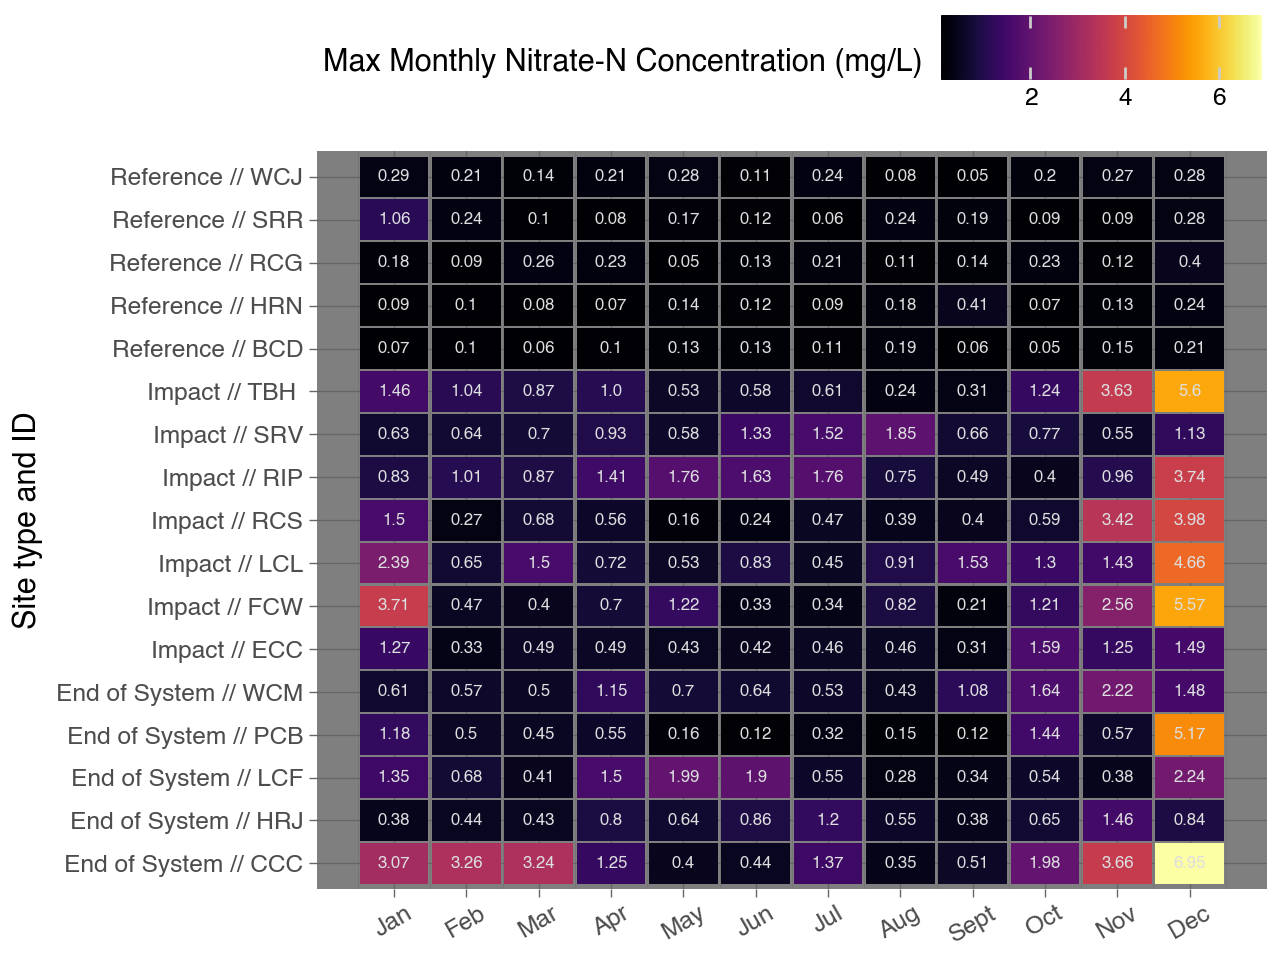

In [140]:
(
    ggplot(df, aes(x='ts', y='combined_col', fill='value')) +
    geom_tile(aes(width=0.95, height=0.95)) +
    theme_dark(base_size=11, base_family=None) +
    geom_text(aes(label="value.round(2).astype(str)"), size=6, color='#DDDEDF', show_legend=False) +
    #scale_color_manual(["white", "black"]) +
    scale_fill_cmap(cmap_name="inferno", name="Max Monthly Nitrate-N Concentration (mg/L)") +
    #scale_fill_gradient(cmap_name="viridis", low="#3BC4A4", high="#CC334E") +  # Adjust low and high colors as needed
    scale_x_continuous(breaks=range(1, 13), labels=month_names, name="") +
    scale_y_discrete(name="Site type and ID") +  # Change y-axis label
    theme(axis_text_x=element_text(angle=30, hjust=1.5),
          legend_position='top',  # Move legend to the top
          legend_direction='horizontal')  # Horizontal orientation of legend
)

This graph displays the maximum monthly Nitrate-N concentration (measured in mg/L) for various sites over a year. Here are some key observations:

- The data is organized by site type and ID on the y-axis, with months on the x-axis.
- Site types are categorized as Reference, Impact, and End of System.
- The concentration values are represented by both numbers and a color scale, with darker colors indicating lower concentrations and brighter colors (yellow) indicating higher concentrations.
- Generally, the Impact and End of System sites show higher nitrate concentrations compared to Reference sites.
- Some sites, particularly Impact sites like TBH, FCW, and LCL, show very high concentrations (above 4 mg/L) in certain months.
- There's considerable variation both across sites and across months for individual sites.
- The highest recorded concentration appears to be 6.96 mg/L at the End of System // CCC site in December.
- Reference sites generally maintain lower concentrations throughout the year.
- Some sites show clear seasonal patterns, while others have more sporadic high concentration months.

This graph allows for comparison of nitrate levels across different types of sites and seasons, which could be useful for environmental monitoring or water quality assessment. 